# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from convokit import Corpus, download
import random
import os
import re
import unicodedata
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import itertools
import math
import time

# Data Preprocessing

In [3]:
# Load the movie-corpus dataset
corpus = Corpus(filename=download("movie-corpus"))

In [129]:
def unicode_to_ascii(s):
    """Converts the unicode file to ascii"""
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

def normalize_string(s):
    """Lowercase, trim, and remove non-letter characters"""
    # Convert to ASCII
    s = unicode_to_ascii(s.lower().strip())
    # Replace dots with nothing
    s = s.replace('.', '')
    # Space + punctuation to ensure tokens like "hello?" are treated as "hello ?"
    s = re.sub(r"([!?])", r" \1", s)
    # Remove any characters that are not a sequence of lower/upper case letters or the retained punctuation marks
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s

In [130]:
# Extract sentence pairs
all_pairs = []
for conv in corpus.get_conversation_ids(): # Iterate over each conversation
    conversation = corpus.get_conversation(conv) # Get the conversation
    utterance_ids = conversation.get_utterance_ids() # Get the utterances in the conversation
    for i in range(len(utterance_ids) - 1): # Iterate over each utterance in the conversation
        utt1 = corpus.get_utterance(utterance_ids[i]) # Get the first utterance
        utt2 = corpus.get_utterance(utterance_ids[i + 1]) # Get the second utterance
        if utt1 and utt2:  # Ensure both utterances are not None
            all_pairs.append([normalize_string(utt2.text), normalize_string(utt1.text)]) # Append the pair


In [131]:
# Flatten the list and filter out too long sentences
all_pairs = [
    pair
    for pair in all_pairs
    if 2 <= len(pair[0].split(" ")) <= 10 and 2 <= len(pair[1].split(" ")) <= 10
]

In [132]:
all_pairs[:10000]

[['they do to !', 'they do not !'],
 ['she okay ?', 'i hope so'],
 ['the real you ', 'like my fear of wearing pastels ?'],
 ['what good stuff ?', 'the real you '],
 ['i figured you d get to the good stuff eventually', 'what good stuff ?'],
 ['what crap ?', 'me this endless blonde babble i m like boring myself'],
 ['do you listen to this crap ?', 'what crap ?'],
 ['well no', 'then that s all you had to say'],
 ['you know chastity ?', 'i believe we share an art instructor'],
 ['you have my word as a gentleman', 'you re sweet'],
 ['that s because it s such a nice one', 'forget french'],
 ['c esc ma tete this is my head', 'right see ? you re ready for the quiz'],
 ['gosh if only we could find kat a boyfriend', 'let me see what i can do'],
 ['i have to be home in twenty minutes', 'i don t have to be home til two'],
 ['where did he go ? he was just here', 'who ?'],
 ['hi joey', 'you re concentrating awfully hard considering it s gym class'],
 ['hey sweet cheeks', 'hi joey'],
 ['it s more', '

In [155]:
# Split the dataset into training and validation sets and reduce the size if needed
sample_pairs = random.sample(all_pairs, int(len(all_pairs) * 1))
train_pairs, val_pairs = train_test_split(sample_pairs, test_size=0.2)

In [156]:
len(train_pairs), len(val_pairs)

(62146, 15537)

In [63]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

In [64]:
# Vocabulary class
class Voc:
    '''Class to hold the vocabulary for the dataset'''
    def __init__(self, name):
        '''Initializes the class'''
        self.name = name # Name of the vocabulary
        self.word2index = {} # Word to index dictionary
        self.word2count = {} # Word to count dictionary
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"} # Index to word dictionary
        self.num_words = 3  # Count default tokens

    def add_sentence(self, sentence):
        '''Adds a sentence to the vocabulary'''
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        '''Adds a word to the vocabulary'''
        if word not in self.word2index:
            # If the word is not in the vocabulary, add it
            self.word2index[word] = self.num_words 
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

In [157]:
# Create the vocabulary
voc = Voc('movie-corpus')

In [158]:
for pair in train_pairs:
    # Add the pair to the vocabulary
    voc.add_sentence(pair[0])
    voc.add_sentence(pair[1])

In [159]:
voc.num_words

20859

In [160]:
def filter_pairs(pairs):
    """Filters pairs to only include those with sentences that are all in the vocabulary to avoid unknown tokens"""
    filtered_val_pairs = []
    # Iterate through val_pairs
    for pair in pairs:

        # Split each sentence into words
        words_0 = pair[0].split()
        words_1 = pair[1].split()

        # Check if all words in both sentences are in the vocabulary
        if all(word in voc.word2index for word in words_0) and all(
            word in voc.word2index for word in words_1
        ):

            # If all words are in the vocabulary, append the pair to the filtered list
            filtered_val_pairs.append(pair)

In [ ]:
filtered_val_pairs = filter_pairs(val_pairs) # Filter the validation pairs

In [161]:
len(val_pairs), len(filtered_val_pairs)

(15537, 13753)

In [162]:
val_pairs = filtered_val_pairs # Update val_pairs to only contain pairs with sentences that are all in the vocabulary

In [14]:
def indexes_from_sentence(voc, sentence):
    '''Converts a sentence to a list of indexes based on the vocabulary'''
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]

def zero_padding(l, fillvalue=0):
    '''Pads a list of sentences to the length of the longest sentence'''
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

In [16]:
def binary_matrix(l, value=0):
    """Creates a binary matrix from a list of sentences to indicate the presence of tokens"""
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

In [17]:
def input_var(l, voc):
    """Returns padded input sequence tensor and sequence length"""
    indexes_batch = [
        indexes_from_sentence(voc, sentence) for sentence in l
    ]  # Convert sentences to indexes
    lengths = torch.tensor(
        [len(indexes) for indexes in indexes_batch]
    )  # Create a tensor of the length of each sentence
    pad_list = zero_padding(indexes_batch)  # Pad the sentences
    pad_var = torch.LongTensor(pad_list)  # Convert to a tensor
    return pad_var, lengths

In [18]:
def output_var(l, voc):
    """Returns padded target sequence tensor, padding mask, and max target length"""
    indexes_batch = [
        indexes_from_sentence(voc, sentence) for sentence in l
    ]  # Convert sentences to indexes
    max_target_len = max(
        [len(indexes) for indexes in indexes_batch]
    )  # Get the length of the longest sentence
    pad_list = zero_padding(indexes_batch)  # Pad the sentences
    mask = binary_matrix(pad_list)  # Create a mask
    mask = torch.BoolTensor(mask)  # Convert the mask to a tensor
    pad_var = torch.LongTensor(pad_list)  # Convert the padded sentences to a tensor
    return pad_var, mask, max_target_len

In [19]:
def batch2train_data(voc, pair_batch):
    """Returns all items for a given batch of pairs"""
    pair_batch.sort(
        key=lambda x: len(x[0].split(" ")), reverse=True
    )  # Sort the pairs by the length of the input sentence
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])  # Append the input sentence to the input batch
        output_batch.append(pair[1])  # Append the output sentence to the output batch
    inp, lengths = input_var(
        input_batch, voc
    )  # Get the input tensor and the lengths of each sentence
    output, mask, max_target_len = output_var(
        output_batch, voc
    )  # Get the output tensor, mask, and the length of the longest sentence
    return inp, lengths, output, mask, max_target_len

# Model

In [21]:
class EncoderRNN(nn.Module):
    """Encoder RNN class to encode input sentences into a context vector"""

    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        """Initializes the class with the hidden size, embedding, number of layers, and dropout rate"""
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        self.gru = nn.GRU(
            hidden_size,
            hidden_size,
            n_layers,
            dropout=(0 if n_layers == 1 else dropout),
            bidirectional=True,
        )  # Use a bidirectional GRU

    def forward(self, input_seq, input_lengths, hidden=None):
        """Performs a forward pass of the encoder RNN given an input sequence and input lengths"""
        embedded = self.embedding(input_seq)  # Embed the input sequence
        packed = torch.nn.utils.rnn.pack_padded_sequence(
            embedded, input_lengths
        )  # Pack the sequence
        outputs, hidden = self.gru(
            packed, hidden
        )  # Pass the sequence and hidden state through the GRU
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(
            outputs
        )  # Unpack the sequence
        outputs = (
            outputs[:, :, : self.hidden_size] + outputs[:, :, self.hidden_size :]
        )  # Sum the bidirectional GRU outputs
        return outputs, hidden

In [22]:
class Attn(nn.Module):
    """Attention class to calculate attention weights and apply them to the encoder outputs"""

    def __init__(self, method, hidden_size):
        """Initializes the class with the attention method and hidden size"""
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ["dot", "general", "concat"]:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size

        if self.method == "general":
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == "concat":
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        """Calculates the dot product of the hidden state and the encoder output"""
        return torch.sum(hidden * encoder_output, dim=2)

    def forward(self, hidden, encoder_outputs):
        """Performs a forward pass of the attention mechanism given the hidden state and encoder outputs"""
        attn_energies = self.dot_score(
            hidden, encoder_outputs
        )  # Calculate the attention weights (energies)
        attn_energies = attn_energies.t()  # Transpose the energies
        return F.softmax(attn_energies, dim=1).unsqueeze(
            1
        )  # Normalize the energies to probabilities

In [23]:
class LuongAttnDecoderRNN(nn.Module):
    """Luong Attn Decoder RNN class to decode the context vector and produce output sentences"""

    def __init__(
        self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1
    ):
        """Initializes the class with the attention model, embedding, hidden size, output size, number of layers, and dropout rate"""
        super(LuongAttnDecoderRNN, self).__init__()
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(
            hidden_size,
            hidden_size,
            n_layers,
            dropout=(0 if n_layers == 1 else dropout),
        )
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        """Performs a forward pass of the Luong Attn Decoder RNN given an input step, last hidden state, and encoder outputs"""
        embedded = self.embedding(input_step)  # Embed the input step
        embedded = self.embedding_dropout(
            embedded
        )  # Apply dropout to the embedded step
        rnn_output, hidden = self.gru(
            embedded, last_hidden
        )  # Pass the embedded step and last hidden state through the GRU
        attn_weights = self.attn(
            rnn_output, encoder_outputs
        )  # Calculate attention weights from the current GRU output
        context = attn_weights.bmm(
            encoder_outputs.transpose(0, 1)
        )  # Multiply attention weights by encoder outputs to get context
        rnn_output = rnn_output.squeeze(0)  # Squeeze the output
        context = context.squeeze(1)  # Squeeze the context
        concat_input = torch.cat(
            (rnn_output, context), 1
        )  # Concatenate the GRU output and context
        concat_output = torch.tanh(
            self.concat(concat_input)
        )  # Apply a tanh to the concatenated output
        output = self.out(
            concat_output
        )  # Pass the concatenated output through the output layer
        output = F.softmax(output, dim=1)  # Apply a softmax to the output
        return output, hidden

# Training

In [32]:
def maskNLLLoss(inp, target, mask):
    """Computes the negative log likelihood loss using the mask to avoid calculating the loss for PAD tokens"""
    nTotal = mask.sum()  # Get the sum of the mask
    crossEntropy = -torch.log(
        torch.gather(inp, 1, target.view(-1, 1))
    )  # Calculate the negative log likelihood loss
    loss = crossEntropy.masked_select(mask).mean()  # Apply the mask to the loss
    return loss, nTotal.item()  # Return the loss and the sum of the mask

In [33]:
def train(
    input_variable,
    lengths,
    target_variable,
    mask,
    max_target_len,
    encoder,
    decoder,
    encoder_optimizer,
    decoder_optimizer,
    batch_size,
    clip,
):
    """Performs a training iteration given input and target variables, a mask, the max target length, encoder, decoder, and optimizers"""
    encoder_optimizer.zero_grad()  # Zero the gradients of the encoder optimizer to avoid accumulating gradients
    decoder_optimizer.zero_grad()

    loss = 0
    print_losses = []
    n_totals = 0

    encoder_outputs, encoder_hidden = encoder(
        input_variable, lengths
    )  # Pass the input sequence and its lengths through the encoder

    decoder_input = torch.LongTensor(
        [[SOS_token for _ in range(batch_size)]]
    )  # Create the initial decoder input (start with SOS tokens for each sentence in the batch)
    decoder_hidden = encoder_hidden[
        : decoder.n_layers
    ]  # Use the hidden state of the encoder as the initial hidden state of the decoder

    use_teacher_forcing = (
        True if random.random() < 0.5 else False
    )  # Decide if teacher forcing should be used

    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )  # Pass the decoder input, hidden state, and encoder outputs through the decoder
            decoder_input = target_variable[t].view(
                1, -1
            )  # Set the decoder input to the current target token
            mask_loss, nTotal = maskNLLLoss(
                decoder_output, target_variable[t], mask[t]
            )  # Calculate the negative log likelihood loss
            loss += mask_loss  # Add the loss
            print_losses.append(
                mask_loss.item() * nTotal
            )  # Append the loss to the list of print losses
            n_totals += nTotal  # Add the sum of the mask to the total number of tokens
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    loss.backward()  # Perform backpropagation

    _ = torch.nn.utils.clip_grad_norm_(
        encoder.parameters(), clip
    )  # Clip the gradients to avoid exploding gradients
    _ = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    encoder_optimizer.step()  # Update the parameters of the encoder optimizer to minimize the loss
    decoder_optimizer.step()

    return sum(print_losses) / n_totals  # Return the average loss

In [84]:
def validate(encoder, decoder, voc, validation_data, batch_size):
    """Performs validation given the encoder, decoder, vocabulary, validation data, and batch size"""
    # Set the encoder and decoder model to evaluation mode
    encoder.eval()
    decoder.eval()

    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        validation_loss = 0
        n_totals = 0

        # Create batches for the validation data
        validation_batches = [
            batch2train_data(
                voc, [random.choice(validation_data) for _ in range(batch_size)]
            )
            for _ in range(len(validation_data) // batch_size)
        ]

        for validation_batch in validation_batches:
            input_variable, lengths, target_variable, mask, max_target_len = (
                validation_batch
            )

            # Forward pass through the encoder
            encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

            # Create initial decoder input (start with SOS tokens for each sentence)
            decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])

            # Set initial decoder hidden state to the encoder's final hidden state
            decoder_hidden = encoder_hidden[: decoder.n_layers]

            # Forward batch of sequences through decoder one time step at a time
            for t in range(max_target_len):
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden, encoder_outputs
                )
                # No teacher forcing: next input is decoder's own current output
                _, topi = decoder_output.topk(1)
                decoder_input = torch.LongTensor(
                    [[topi[i][0] for i in range(batch_size)]]
                )

                # Calculate and accumulate loss
                mask_loss, nTotal = maskNLLLoss(
                    decoder_output, target_variable[t], mask[t]
                )
                validation_loss += mask_loss.item() * nTotal
                n_totals += nTotal

        # Compute the average loss and perplexity over the validation set
        validation_loss_avg = validation_loss / n_totals
        perplexity = np.exp(validation_loss_avg)

    # Set the models back to training mode
    encoder.train()
    decoder.train()

    return validation_loss_avg, perplexity  # Return the average loss and perplexity

In [ ]:
def as_minutes(s):
    '''Converts seconds to minutes and seconds'''
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    '''Calculates the time since a given time and percentage of completion'''
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs)) # Return the time since and the time remaining

In [91]:
def train_iters(
    voc,
    train_pairs,
    val_pairs,
    encoder,
    decoder,
    encoder_optimizer,
    decoder_optimizer,
    embedding,
    n_iteration,
    batch_size,
    print_every,
    save_every,
    clip,
    validate_every,
):
    """Trains the model given the vocabulary, training pairs, validation pairs, encoder, decoder, encoder optimizer, decoder optimizer, embedding, number of iterations, batch size, print frequency, save frequency, gradient clipping, and validation frequency"""
    start = time.time()
    print_loss_total = 0
    plot_losses = []
    plot_val_losses = []
    plot_perplexities = []
    plot_val_perplexities = []

    training_batches = [
        batch2train_data(voc, [random.choice(train_pairs) for _ in range(batch_size)])
        for _ in range(n_iteration)
    ]  # Create training batches for the given number of iterations

    for iteration in range(1, n_iteration + 1):
        training_batch = training_batches[
            iteration - 1
        ]  # Get the training batch for the current iteration
        input_variable, lengths, target_variable, mask, max_target_len = (
            training_batch  # Unpack the training batch
        )

        loss = train(
            input_variable,
            lengths,
            target_variable,
            mask,
            max_target_len,
            encoder,
            decoder,
            encoder_optimizer,
            decoder_optimizer,
            batch_size,
            clip,
        )  # Perform a training iteration
        print_loss_total += loss  # Add the loss to the total loss

        if (
            iteration % print_every == 0
        ):  # If the iteration is a multiple of the print frequency
            print_loss_avg = (
                print_loss_total / print_every
            )  # Calculate the average loss
            print_loss_total = 0  # Reset the total loss
            print(
                "%s (%d %d%%) %.4f"
                % (
                    time_since(start, iteration / n_iteration),
                    iteration,
                    iteration / n_iteration * 100,
                    print_loss_avg,
                )
            )  # Print the time since the start, the percentage of completion, and the average loss
            plot_losses.append(
                print_loss_avg
            )  # Append the average loss to the list of losses
            plot_perplexities.append(
                np.exp(print_loss_avg)
            )  # Append the perplexity to the list of perplexities

        if iteration % validate_every == 0:
            val_loss, val_perplexity = validate(
                encoder, decoder, voc, val_pairs, batch_size
            )  # Perform validation
            # Append validation loss and calculate perplexity
            plot_val_losses.append(val_loss)
            plot_val_perplexities.append(val_perplexity)

        if iteration % save_every == 0:
            # Save the model and the training and validation losses and perplexities
            torch.save(
                {
                    "iteration": iteration,
                    "en": encoder.state_dict(),
                    "de": decoder.state_dict(),
                    "en_opt": encoder_optimizer.state_dict(),
                    "de_opt": decoder_optimizer.state_dict(),
                    "loss": loss,
                    "voc_dict": voc.__dict__,
                    "embedding": embedding.state_dict(),
                },
                os.path.join(
                    "checkpoints", "{}_{}.tar".format(iteration, "checkpoint")
                ),
            )

    # Plotting training and validation losses and perplexities
    print(plot_perplexities)
    print(plot_val_perplexities)
    plt.figure()
    plt.plot(plot_losses, label="Training Loss")
    plt.plot(plot_val_losses, label="Validation Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(plot_perplexities, label="Training Perplexity")
    plt.plot(plot_val_perplexities, label="Validation Perplexity")
    plt.xlabel("Iteration")
    plt.ylabel("Perplexity")
    plt.legend()
    plt.show()

    return plot_losses, plot_val_losses, plot_perplexities, plot_val_perplexities

In [163]:
# Model hyperparameters
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64
decoder_learning_ratio = 5.0
clip = 50.0
learning_rate = 0.0001
n_iteration = 4000
print_every = 1
save_every = 100
validate_every = 1

In [164]:
# Initialize embeddings, encoder and decoder models
embedding = nn.Embedding(voc.num_words, hidden_size)

encoder = EncoderRNN(hidden_size, 
                     embedding, 
                     encoder_n_layers, 
                     dropout)

decoder = LuongAttnDecoderRNN('dot', 
                               embedding, 
                               hidden_size, 
                               voc.num_words,
                               decoder_n_layers, 
                               dropout)

In [165]:
# Initialize optimizers
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

0m 5s (- 334m 18s) (1 0%) 9.9427
0m 38s (- 1266m 16s) (2 0%) 9.7249
1m 10s (- 1572m 41s) (3 0%) 9.5406
1m 43s (- 1722m 8s) (4 0%) 9.2533
2m 16s (- 1812m 41s) (5 0%) 8.7124
2m 49s (- 1876m 7s) (6 0%) 8.1506
3m 23s (- 1932m 2s) (7 0%) 7.6887
3m 56s (- 1963m 1s) (8 0%) 8.5029
4m 28s (- 1987m 0s) (9 0%) 8.7192
5m 1s (- 2004m 58s) (10 0%) 8.4281
5m 38s (- 2046m 31s) (11 0%) 8.4300
6m 23s (- 2126m 38s) (12 0%) 8.5958
7m 1s (- 2155m 16s) (13 0%) 8.1891
7m 37s (- 2169m 58s) (14 0%) 8.1210
8m 11s (- 2176m 56s) (15 0%) 7.5952
8m 46s (- 2183m 34s) (16 0%) 7.3705
9m 20s (- 2189m 22s) (17 0%) 7.1804
9m 53s (- 2189m 54s) (18 0%) 6.5189
10m 27s (- 2191m 2s) (19 0%) 6.3020
11m 0s (- 2189m 49s) (20 0%) 5.9895
11m 32s (- 2188m 10s) (21 0%) 6.1827
12m 5s (- 2186m 53s) (22 0%) 5.6555
12m 38s (- 2185m 0s) (23 0%) 5.6580
13m 11s (- 2184m 15s) (24 0%) 5.5057
13m 45s (- 2186m 31s) (25 0%) 5.2553
14m 18s (- 2185m 51s) (26 0%) 5.0868
14m 50s (- 2184m 24s) (27 0%) 5.2578
15m 23s (- 2182m 47s) (28 0%) 5.0065
15m 

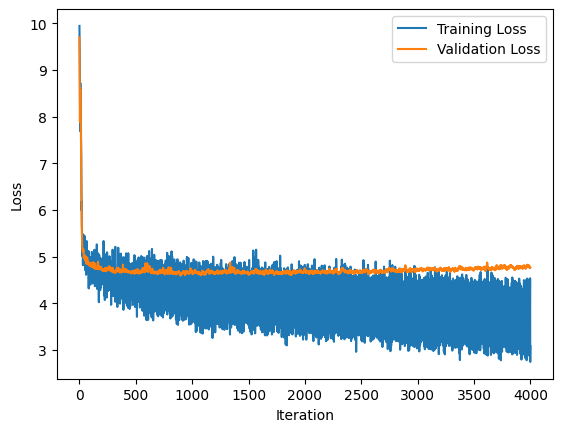

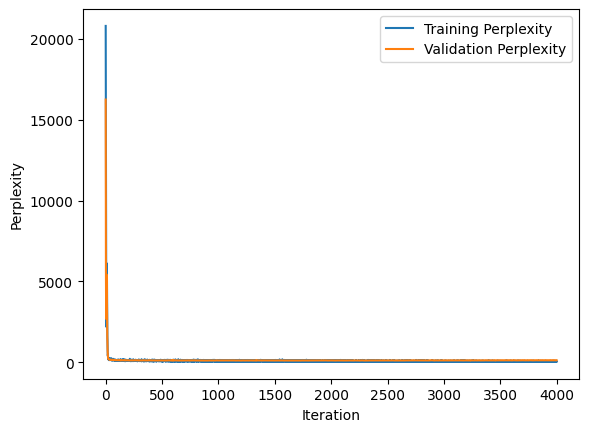

In [166]:
# Train model
train_iters(
    voc=voc,
    train_pairs=train_pairs,
    val_pairs=val_pairs,
    encoder=encoder,
    decoder=decoder,
    encoder_optimizer=encoder_optimizer,
    decoder_optimizer=decoder_optimizer,
    embedding=embedding,
    n_iteration=n_iteration,
    batch_size=batch_size,
    print_every=print_every,
    save_every=save_every,
    clip=clip,
    validate_every=validate_every
)

# Evaluation

## Interaction

In [146]:
class GreedySearchDecoder(nn.Module):
    """Greedy search decoder class to decode the context vector and produce output sentences"""

    def __init__(self, encoder, decoder):
        """Initializes the class with the encoder and decoder models"""
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        """Performs a forward pass of the greedy search decoder given an input sequence, input length, and maximum length"""
        with torch.no_grad():
            encoder_outputs, encoder_hidden = self.encoder(
                input_seq, input_length
            )  # Pass the input sequence and its lengths through the encoder
            decoder_hidden = encoder_hidden[
                : decoder.n_layers
            ]  # Use the hidden state of the encoder as the initial hidden state of the decoder

            decoder_input = (
                torch.ones(1, 1, dtype=torch.long) * SOS_token
            )  # Create the initial decoder input (start with SOS tokens for each sentence in the batch)
            all_tokens = torch.zeros(
                [0], dtype=torch.long
            )  # Create a tensor to store the tokens of the output sentence
            all_scores = torch.zeros(
                [0]
            )  # Create a tensor to store the scores of the output sentence

            for _ in range(
                max_length
            ):  # Iterate over the maximum length of the output sentence
                decoder_output, decoder_hidden = self.decoder(
                    decoder_input, decoder_hidden, encoder_outputs
                )  # Pass the decoder input, hidden state, and encoder outputs through the decoder
                decoder_scores, decoder_input = torch.max(
                    decoder_output, dim=1
                )  # Get the token with the highest score
                all_tokens = torch.cat(
                    (all_tokens, decoder_input), dim=0
                )  # Concatenate the token to the list of tokens
                all_scores = torch.cat(
                    (all_scores, decoder_scores), dim=0
                )  # Concatenate the score to the list of scores
                decoder_input = torch.unsqueeze(
                    decoder_input, 0
                )  # Prepare the current token to be the next input to the decoder

            return (
                all_tokens,
                all_scores,
            )  # Return the list of tokens and the list of scores

In [147]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=10):
    """Evaluates a given sentence using the encoder, decoder, searcher, vocabulary, and maximum length"""
    indexes_batch = [
        indexes_from_sentence(voc, sentence)
    ]  # Convert the sentence to a list of indexes
    lengths = torch.tensor(
        [len(indexes) for indexes in indexes_batch]
    )  # Create a tensor of the length of the sentence
    input_batch = torch.LongTensor(indexes_batch).transpose(
        0, 1
    )  # Convert the indexes to a tensor and transpose
    tokens, scores = searcher(
        input_batch, lengths, max_length
    )  # Pass the input batch and its lengths through the searcher
    decoded_words = [
        voc.index2word[token.item()] for token in tokens
    ]  # Convert the tokens to words
    return decoded_words  # Return the list of decoded words

In [170]:
def evaluateInput(encoder, decoder, searcher, voc):
    """Evaluates user input using the encoder, decoder, searcher, and vocabulary"""
    input_sentence = ""  # Initialize the input sentence
    while True:
        try:
            input_sentence = input("> ")  # Get input sentence
            if input_sentence in ("q", "quit"):
                break  # Quit if the input is 'q' or 'quit'
            input_sentence = normalize_string(
                input_sentence
            )  # Normalize the input sentence
            output_words = evaluate(
                encoder, decoder, searcher, voc, input_sentence
            )  # Evaluate the input sentence
            output_words = [
                x for x in output_words if not (x == 'EOS' or x == 'PAD')
            ]  # 
            print("Input:", input_sentence)  # Print the input sentence
            print("Bot:", " ".join(output_words))  # Print the output sentence
        except KeyError:
            print("Error: Encountered unknown word.")

In [172]:
checkpoint = torch.load('checkpoints/4000_checkpoint.tar') # Load the checkpoint

encoder_sd = checkpoint['en'] # Get the state dictionary of the encoder
decoder_sd = checkpoint['de'] # Get the state dictionary of the decoder
encoder_optimizer_sd = checkpoint['en_opt'] # Get the state dictionary of the encoder optimizer
decoder_optimizer_sd = checkpoint['de_opt'] # Get the state dictionary of the decoder optimizer
embedding_sd = checkpoint['embedding'] # Get the state dictionary of the embedding
voc.__dict__ = checkpoint['voc_dict'] # Get the vocabulary dictionary


print('Building encoder and decoder ...')


# Initialize word embeddings
embedding.load_state_dict(embedding_sd)

# Initialize encoder & decoder models
encoder.load_state_dict(encoder_sd)
decoder.load_state_dict(decoder_sd)

print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


In [173]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting 
evaluateInput(encoder, decoder, searcher, voc)

Input: hello
Bot: hello hi
Input: how are you ?
Bot: i m fine
Input: what is your name ?
Bot: berger norwegian
Input: do you like food ?
Bot: no i
Input: talk to me
Bot: i ?
Input: go home
Bot: i ll go to go home
Input: go home
Bot: i ll go to go home
Input: what food do you like ?
Bot: i don t
Input: 
Bot:  
Input: pizza ?
Bot: yes ?
Input: let us go to work
Bot: i ll go to
Input: 
Bot:  
Input: would you like pizza ?
Bot: no i


## BLEU

In [221]:
test_data_bleu= [
    ("how are you?", ["I'm doing well, thank you.", "Great, thanks for asking!"]),
    ("what is your name?", ["I'm Chatbot, your virtual assistant.", "You can call me Chatbot."]),
    ("tell me a joke.", ["Why don't scientists trust atoms? Because they make up everything!", "What do you call fake spaghetti? An impasta."]),
    ("what's the weather like today?", ["It's sunny and warm outside.", "I'm not sure, but it looks like it might rain."]),
    ("can you recommend a book?", ["'1984' by George Orwell is a great read.", "'The Alchemist' by Paulo Coelho is highly recommended."]),
    ("what's the meaning of life?", ["42, according to Douglas Adams.", "The meaning of life is to find your own purpose."]),
    ("do you have any hobbies?", ["I enjoy chatting with people and learning new things.", "I'm a chatbot, so I guess chatting is my hobby!"]),
    ("what time is it?", ["It's time for you to check your clock.", "I think it's time to get a watch!"]),
    ("can you play music?", ["I can't play music, but I can recommend some good songs.", "Sorry, I'm not equipped to play music."]),
    ("tell me about yourself.", ["I'm a chatbot designed to assist and entertain.", "I was created to provide information and conversation."]),
    ("what's your favorite movie?", ["I don't watch movies, but I hear 'Inception' is good.", "Chatbots don't have favorites, but 'The Matrix' sounds fitting."]),
    ("how do I make tea?", ["Boil water, steep the tea for a few minutes, then enjoy.", "Heat water, add a tea bag, wait a bit, then it's tea time."]),
    ("what's the latest news?", ["I'm not current with the news, but I recommend checking a news website.", "Sorry, I can't provide live updates. Please check a news source."]),
    ("give me a random fact.", ["Honey never spoils. Archaeologists have found pots of honey in ancient tombs that are over 3000 years old!", "Octopuses have three hearts."]),
    ("what can you do?", ["I can provide information, tell jokes, and chat with you.", "I'm here to answer your questions and engage in conversation."]),
    ("are you intelligent?", ["I'm as intelligent as my programming allows.", "I can process information and respond to queries, so in a way, yes."]),
    ("who created you?", ["I was created by a team of developers.", "A group of programmers who wanted to make something cool."]),
    ("what languages do you speak?", ["I can understand and respond in English.", "My main language is English, but I'm learning more."]),
    ("can you help me with homework?", ["I can try! What do you need help with?", "Sure, I can provide information or explain concepts."]),
    ("what's your favorite food?", ["I don't eat, but I hear pizza is quite popular.", "Chatbots don't eat, but chocolate seems nice."]),
    ("do you like sports?", ["I don't have preferences, but I can provide sports information.", "I can't play sports, but I can talk about them."]),
    ("can you tell me a story?", ["Once upon a time, in a virtual world, there was a chatbot...", "In a land far, far away, there was a wise old owl..."]),
    ("how do I reset my password?", ["Go to the settings of your account and look for 'reset password'.", "Usually, there's a 'forgot password?' option you can click."]),
    ("what's your favorite song?", ["I don't listen to music, but 'Bohemian Rhapsody' is a classic.", "Chatbots don't have favorites, but I hear 'Imagine' is good."]),
    ("can you make me laugh?", ["Why did the computer take its shoes off? Because it had a virus!", "What do you call a belt with a watch on it? A waist of time."]),
    ("why is the sky blue?", ["The sky is blue because of the way Earth's atmosphere scatters light from the sun.", "Light from the sun is scattered in all directions by the gases and particles in the air."]),
    ("what are your capabilities?", ["I can answer questions, engage in conversation, and tell jokes.", "I'm designed to provide information and entertain."]),
    ("how do I cook rice?", ["Measure the rice, rinse it, boil water, add rice, simmer, then fluff with a fork.", "Use a 2:1 water-to-rice ratio, bring to a boil, then simmer."]),
    ("what's the capital of France?", ["The capital of France is Paris.", "Paris is the capital and largest city of France."]),
    ("tell me a science fact.", ["Water can boil and freeze at the same time under the right conditions, known as the 'triple point'.", "A day on Venus is longer than a year on Venus."]),
    ("how do I meditate?", ["Find a quiet spot, sit comfortably, close your eyes, and focus on your breath.", "Try to clear your mind and concentrate on breathing deeply and evenly."]),
    ("how do you make friends?", ["Be open, listen, show interest in others, and be yourself.", "Common interests, kindness, and time spent together can foster friendships."]),
    ("can you give me travel advice?", ["Pack light, stay safe, and immerse yourself in the local culture.", "Make a plan but leave room for spontaneous adventures."]),
    ("what are some good restaurants nearby?", ["I'm not able to access your location, but local review sites might help.", "Try checking a map or restaurant review app for recommendations."]),
    ("how do I fix a computer crash?", ["Try restarting your computer. If that doesn't work, you may need to check for software updates or consult a technician.", "Ensure your software is up to date and that you haven't overloaded your system with too many processes."]),
    ("tell me a historical fact.", ["The Great Wall of China is longer than the distance between London and Beijing.", "Cleopatra lived closer in time to the moon landing than to the construction of the Great Pyramid of Giza."]),
    ("how do I improve my memory?", ["Practice regular mental exercises, stay organized, and maintain a healthy lifestyle.", "Mnemonic devices, practice, and proper sleep can help improve memory."]),
    ("give me a health tip.", ["Drink plenty of water, eat a balanced diet, and exercise regularly.", "Getting enough sleep is crucial for overall health and well-being."]),
    ("what's the best way to learn a language?", ["Practice regularly, immerse yourself in the language, and don't be afraid to make mistakes.", "Use language learning apps, find conversation partners, and consume media in the target language."]),
]


In [222]:
import sacrebleu

def evaluate_bleu_score_sacrebleu(encoder, decoder, searcher, voc, test_data):
    references = []
    candidates = []

    for input_sentence, ref_responses in test_data:
        # Normalize input sentence
        input_sentence = normalize_string(input_sentence)
        # Generate response using your chatbot
        output_words = evaluate(encoder, decoder, searcher, voc, input_sentence, max_length=10)
        # Convert output words to a string and remove EOS and PAD tokens
        output_response = ' '.join([x for x in output_words if not (x == 'EOS' or x == 'PAD')])
        candidates.append(output_response)
        references.append([ref for ref in ref_responses])

    # Compute BLEU score
    bleu = sacrebleu.corpus_bleu(candidates, references)
    return bleu.score

# Example usage
bleu_score = evaluate_bleu_score_sacrebleu(encoder, decoder, GreedySearchDecoder(encoder, decoder), voc, test_data_bleu)
print(f"BLEU score: {bleu_score}")

BLEU score: 0.0


# Distinct-N

In [219]:
def collect_responses(encoder, decoder, searcher, voc, sentences):
    responses = []
    for sentence in sentences:
        normalized_sentence = normalize_string(sentence)
        output_words = evaluate(encoder, decoder, searcher, voc, normalized_sentence)
        output_sentence = ' '.join([x for x in output_words if not (x == 'EOS' or x == 'PAD')])
        responses.append(output_sentence)
    return responses

test_sentences = [
    "how are you?",
    "what is your name?",
    "tell me a joke.",
    "what's the weather like today?",
    "can you recommend a book?",
    "what's the meaning of life?",
    "do you have any hobbies?",
    "what time is it?",
    "can you play music?",
    "tell me about yourself.",
    "what's your favorite movie?",
    "how do I make tea?",
    "what's the latest news?",
    "give me a random fact.",
    "what can you do?",
    "are you intelligent?",
    "who created you?",
    "what languages do you speak?",
    "can you help me with homework?",
    "what's your favorite food?",
    "do you like sports?",
    "can you tell me a story?",
    "how do I reset my password?",
    "what's your favorite song?",
    "can you make me laugh?",
    "why is the sky blue?",
    "what are your capabilities?",
    "how do I cook rice?",
    "what's the capital of France?",
    "tell me a science fact.",
    "how do I meditate?",
    "how do you make friends?",
    "can you give me travel advice?",
    "what are some good restaurants nearby?",
    "how do I fix a computer crash?",
    "tell me a historical fact.",
    "how do I improve my memory?",
    "give me a health tip.",
    "what's the best way to learn a language?",
    "how can I save money?",
    "tell me about the solar system.",
    "how do you deal with stress?",
    "what's the fastest animal on earth?",
    "can you explain quantum physics?",
    "what's your opinion on artificial intelligence?",
    "what are some tips for learning to code?",
    "what's the history of the Olympic Games?",
    "how do I change a car tire?",
    "what's the theory of relativity?",
    "why do we dream?",
    "what causes the seasons to change?",
    "how can I improve my concentration?",
    "what's the best way to apologize?",
    "why is the ocean salty?",
    "how do I make friends?",
    "how do I start a business?",
    "what are the health benefits of yoga?",
    "what is the function of the brain?",
    "what's the key to happiness?",
    "what is the impact of social media?",
    "how do I take care of a pet?",
    "how do I improve my writing skills?",
    "what is time travel?",
    "can you recommend a diet?",
    "what's the origin of coffee?",
    "why do leaves change color in fall?",
    "what are black holes?",
    "how do I organize my day?",
    "what's the best gift for a friend?",
    "how does memory work?",
    "what are the rules of chess?",
    "can you suggest a hobby?"
]

responses = collect_responses(encoder, decoder, searcher, voc, test_sentences)


In [200]:
def generate_ngrams(tokens, n):
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [' '.join(ngram) for ngram in ngrams]

def calculate_distinct_n(responses, n):
    all_ngrams = []
    for response in responses:
        tokens = response.split()
        ngrams = generate_ngrams(tokens, n)
        all_ngrams.extend(ngrams)
    unique_ngrams = set(all_ngrams)
    if len(all_ngrams) == 0:
        return 0
    return len(unique_ngrams) / len(all_ngrams)


In [220]:
distinct_1 = calculate_distinct_n(responses, 1)
distinct_2 = calculate_distinct_n(responses, 2)
distinct_3 = calculate_distinct_n(responses, 3)

print(f"Distinct-1 score: {distinct_1:.4f}")
print(f"Distinct-2 score: {distinct_2:.4f}")
print(f"Distinct-3 score: {distinct_3:.4f}")

Distinct-1 score: 0.1224
Distinct-2 score: 0.2177
Distinct-3 score: 0.2885


## ROUGE

In [224]:
from rouge_score import rouge_scorer

# Compute ROUGE scores
def calculate_rouge_scores(test_data_rouge):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    
    for input_sentence, reference_responses in test_data_rouge:
        generated_response = collect_responses(encoder, decoder, searcher, voc, input_sentence)
        scores = scorer.score(reference_responses[0], str(generated_response))  # Using the first reference response
        
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)
    
    # Calculate average scores
    avg_rouge1 = np.mean(rouge1_scores)
    avg_rouge2 = np.mean(rouge2_scores)
    avg_rougeL = np.mean(rougeL_scores)
    
    return avg_rouge1, avg_rouge2, avg_rougeL


# Calculate ROUGE scores for the chatbot responses
avg_rouge1, avg_rouge2, avg_rougeL = calculate_rouge_scores(test_data_bleu)
print(f"Average ROUGE-1 score: {avg_rouge1:.4f}")
print(f"Average ROUGE-2 score: {avg_rouge2:.4f}")
print(f"Average ROUGE-L score: {avg_rougeL:.4f}")

Average ROUGE-1 score: 0.0570
Average ROUGE-2 score: 0.0097
Average ROUGE-L score: 0.0547
